In [1]:
import glob
import numpy as np
import os
import ast
import pandas as pd
import h5py 

import cooltools
import cooltools.lib.plotting
import shutil
from scipy.ndimage.filters import gaussian_filter
import matplotlib.pyplot as plt
from scipy import ndimage

import matplotlib.ticker as tkr

/home1/rahmanin/.conda/envs/openmm-env/lib/python3.7/site-packages/cooltools/lib/numutils.py:11: FutureWarning: The `cooler.tools` module is deprecated in v0.9 and will be removed in v0.10. Use `cooler.parallel` instead.
  from ._numutils import (
/home1/rahmanin/.conda/envs/openmm-env/lib/python3.7/site-packages/cooltools/api/expected.py:14: FutureWarning: The `cooler.tools` module is deprecated in v0.9 and will be removed in v0.10. Use `cooler.parallel` instead.
  from cooler.tools import partition


In [3]:
file = pd.read_csv('inputs/data/loop_size_converged_pair.csv')

In [4]:
lifetime = file['life']
velocity = file['vel']
clife = file['clife']
cof = file['cof']

unique_life = np.unique(lifetime)
unique_vel = np.unique(velocity)
unique_clife = np.unique(clife)
unique_cof = np.unique(cof)

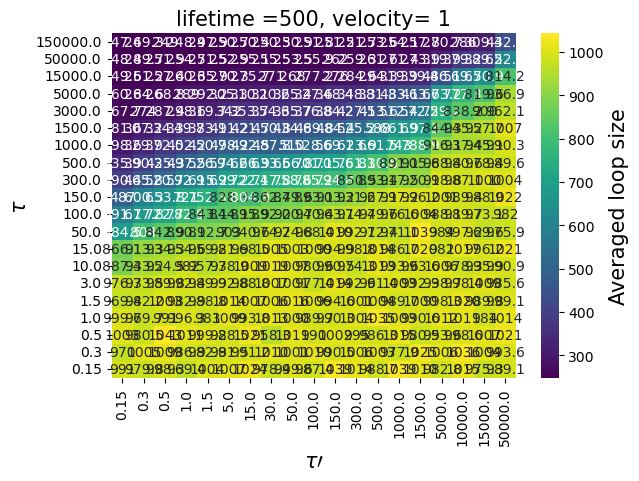

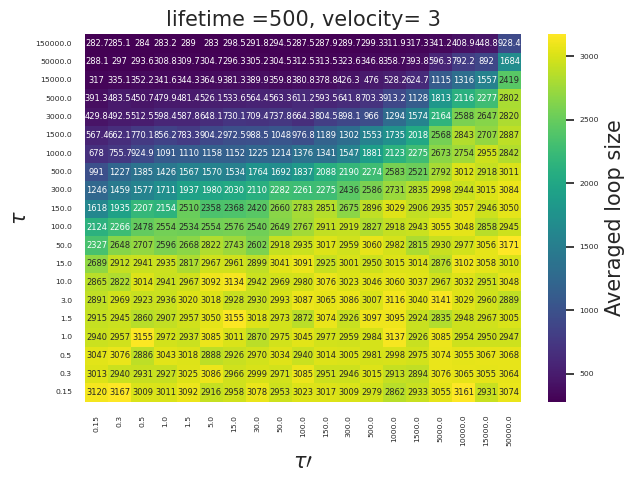

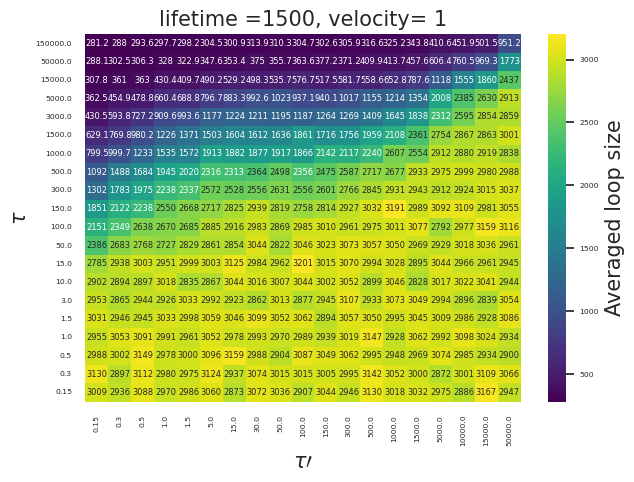

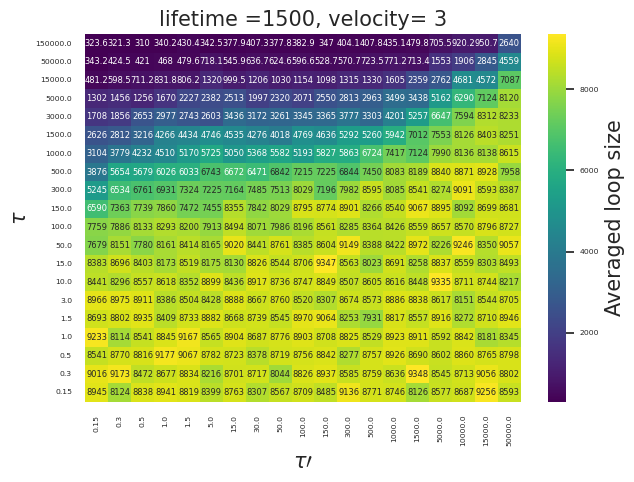

In [5]:
import seaborn as sns

unique_vel = [ 1,3]
unique_life = [ 500, 1500]


c = 1

for life in list(unique_life):
    for vel in list(unique_vel):
        #plt.subplot(1, 1, c)
        
        new_file = file[(lifetime == life) & (velocity == vel)][['clife', 'cof', 'loopmean']]
        heatmap_data = new_file.pivot('clife', 'cof', 'loopmean')
        
        # Create the heatmap using seaborn
        im = sns.heatmap(heatmap_data, annot=True, cmap='viridis',  fmt='.4g', cbar_kws={'label': ' Average of loop size'})
        sns.set(font_scale=0.5)

        # Access the color bar object
        cbar = im.collections[0].colorbar
        
        # Set the font size of color bar label
        cbar.set_label('Averaged loop size', fontsize=15)  # Adjust the font size as needed
        
        # Customize labels and title
        plt.xlabel(r'$\tau\prime$', fontsize=15)
        plt.ylabel(r'$\tau$', fontsize=15)
        plt.title('lifetime =%s, velocity= %s' % (life, vel),fontsize =15)
        plt.gca().invert_yaxis()
        
        c += 1


        plt.tight_layout()
        #plt.savefig('averaged_loop_size_life_%s_vel_%s_sep_%s.png'%(life,vel,sep))
        plt.show()

/home1/rahmanin/.conda/envs/openmm-env/lib/python3.7/site-packages/ipykernel_launcher.py:54: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "ppt" which is no longer supported as of 3.3 and will become an error in 3.6


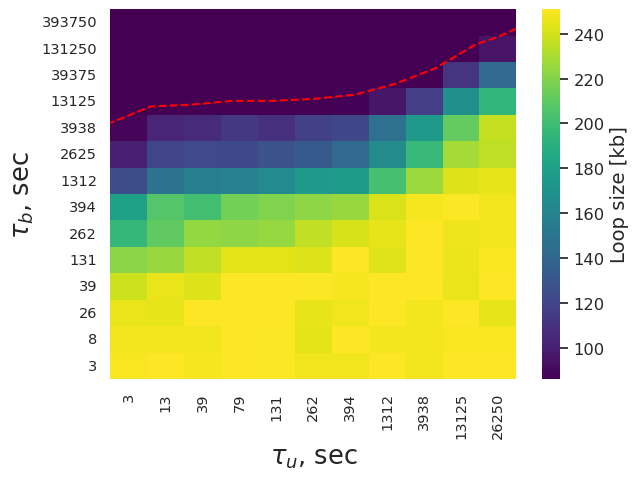

In [6]:
# Define unique values for lifetime and velocity
unique_life = [500]
unique_vel = [1]

c = 1
file = pd.read_csv('inputs/data/loop_size_converged_pair.csv')
convertor = 3
tau_range = [1,  3,5, 10, 15, 30, 50, 100, 150, 500, 1000, 1500,5000, 15000, 50000, 150000]
taup_range = [ 1.0,  3,5.0, 10.0, 15,30,  50, 100, 150,500, 1500, 5000, 10000]
file = file[file['clife'].isin(tau_range)]
file = file[file['cof'].isin(taup_range)]
convertor= 21.875*60/500
file['clife']=(file['clife']*convertor).round().astype(int)
file['cof']=(file['cof']*convertor).round().astype(int)
file['loopmean']=file['loopmean']*0.25
for life in unique_life:
    for vel in unique_vel:
        # Filter the data based on lifetime and velocity
        new_file = file[(file['life'] == life) & (file['vel'] == vel)][['clife', 'cof', 'loopmean']]
        
        # Pivot the filtered data to create the heatmap data
        heatmap_data = new_file.pivot('clife', 'cof', 'loopmean')

        fig, ax = plt.subplots()

        smooth_scale = 1
        z = ndimage.zoom(heatmap_data.to_numpy(), smooth_scale)
        
        # Create the heatmap using seaborn
        ax = sns.heatmap(heatmap_data, annot=False, vmin = 86, vmax= 251,cmap='viridis', fmt='.4g', cbar_kws={'label': 'Loop size'})
        sns.set(font_scale=0.53)
        cbar = ax.collections[0].colorbar
        cbar.ax.tick_params(labelsize=11.75)
        # Set the font size of color bar label
        cbar.set_label('Loop size [kb]', fontsize=14.15)

        # Add equipotential lines for loop size = 700
        number_tau = 11
        number_taup =14
        d = gaussian_filter(heatmap_data.to_numpy(), sigma=1)
        smooth_scale = 1
        cntr = ax.contour(np.linspace(0, number_tau, number_tau*smooth_scale),
                           np.linspace(0, number_taup, number_taup*smooth_scale),
                           heatmap_data.to_numpy(), levels=[350*0.25], colors='red', linestyles='dashed') 
        
        # Customize labels and title
        plt.xlabel(r'$\tau_u$, sec', fontsize=18.5)
        plt.ylabel(r'$\tau_b$, sec', fontsize=18.5)
        plt.xticks(fontsize=10.51, rotation=90)
        plt.yticks(fontsize=10.51)

        plt.gca().invert_yaxis()
        plt.tight_layout()
        plt.savefig('output/figures/loopsize_for_pair.pdf',ppt= 500,transparent=True)
        plt.show()


In [7]:
num_plot = 10
viridis_cmap = plt.get_cmap('cividis')

# Generate an array of values from 0 to 1 to map to colors in the colormap
values = np.linspace(0, 1, num_plot)

# Get the corresponding colors from the colormap
colors = viridis_cmap(values)

### data for static

In [9]:
# Directory containing the CSV files
directory_stat = '../../../../../simulations/extruder_between_convergent_static-Copy1/data/'

# Initialize an empty list to store data frames
dfs_stat = []

# Iterate through all files in the directory
for filename in os.listdir(directory_stat):
    if filename.endswith('.csv'):
        # Read the CSV file into a data frame
        filepath = os.path.join(directory_stat, filename)
        df = pd.read_csv(filepath)
        # Append the data frame to the list
        dfs_stat.append(df)

# Concatenate all data frames in the list vertically (along the rows)
merged_df_stat = pd.concat(dfs_stat, ignore_index=True)

# Now merged_df contains all data from CSV files in the directory
merged_df_stat

,life,vel,face,clife,cof,loopmean,loopstd
0,50.0,1,0.20,1.0,0.15,845.664874,872.800362
1,50.0,1,0.90,1.0,0.15,325.510995,303.365105
2,50.0,1,0.05,1.0,0.15,965.394592,985.909717
3,50.0,3,0.80,1.0,0.15,1888.456592,2212.666844
4,50.0,3,0.30,1.0,0.15,2673.735200,2830.296759
5,150.0,1,0.01,1.0,0.15,2945.049844,2950.618764
6,150.0,3,0.20,1.0,0.15,8046.816165,7555.956820
7,150.0,3,0.90,1.0,0.15,4294.122850,5550.195725
8,150.0,1,0.80,1.0,0.15,818.493102,1267.207789
9,150.0,1,0.30,1.0,0.15,2153.124619,2420.221893


In [10]:
file_stat = merged_df_stat

In [11]:
def loop_size(t, v, delta, tau, x , taup):
    if v * t <= delta/2:
        return v * t * 2
    else:
        loop = delta + (taup / (tau + taup)) * v * (t - (delta/2 / v)) * 2
        if t > (x*tau+(delta/2)/(v)):
            loop += (tau / (tau + taup)) * v * (t - (delta/2 / v) - tau*x) * 2
        return loop

In [12]:
x_vals = np.linspace(0.01, 1, 10)
loop_sizes = np.array([loop_size(500, 1, 300, 5000, x, 50) for x in x_vals])
integral = np.trapz(loop_sizes, x_vals)

In [13]:
x_vals = np.linspace(0.01, 1, 10)
loop_sizes = np.array([loop_size(500, 1, 300, 5, x, 5000) for x in x_vals])
x_new_vals = np.linspace(1,10, 10)
integral = np.trapz(loop_sizes, x_vals)
new_int = np.trapz(loop_sizes, x_new_vals)

In [14]:
def loop_size_static(t, v, delta, occupancy):
    if v * t <= delta/2:
        return v * t * 2
    else:
        loop = delta + (1-occupancy) * v * (t - (delta/2 / v)) * 2
        return loop

sns.reset_defaults()

In [15]:
num_plot = 5
viridis_cmap = plt.get_cmap('cividis')

# Generate an array of values from 0 to 1 to map to colors in the colormap
values = np.linspace(0, 1, num_plot)

# Get the corresponding colors from the colormap
colors = viridis_cmap(values)

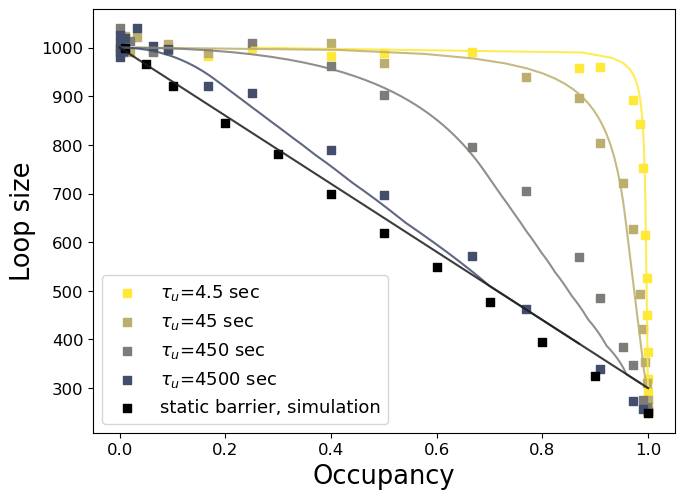

In [16]:
lifes, vels = [500] , [1]
import seaborn as sns
convertor=3
i=1
file = pd.read_csv('../../../../../data/loop_size_converged_pair.csv')
sns.reset_defaults()
plt.figure(figsize=(7.5,5.5))
lifetime = file['life']
velocity = file['vel']
clife = file['clife']
cof = file['cof']
unique_life = np.unique(lifetime)
unique_vel = np.unique(velocity)
unique_clife = np.unique(clife)
unique_cof = np.unique(cof)
cof_val = 10
list_cof = [1.5,15, 150, 1500]
y = [1000, 280]
for cof_val in list_cof:
    for life in lifes:
        for vel in vels:
            v=1
            new_file = file[(lifetime == life)&(velocity == vel)&(cof==cof_val)][['clife','cof', 'loopmean','loopstd']]
            #new_file_filtered = new_file.drop_duplicates(keep = 'first')
            new_file_filtered=new_file
            new_file_filtered = new_file_filtered.sort_values('clife')
            new_clife = new_file_filtered['clife']
            frip_score = new_file_filtered['loopmean']
            std = new_file_filtered['loopstd']
            plt.scatter(new_clife/(new_clife+cof_val), frip_score,  label = r'$\tau_u$=%s sec'%(cof_val*convertor),
                        linewidth=1,s=31.5, marker = 's', color = colors[5-i])
            i+=1
            #plt.errorbar(new_clife/(new_clife+cof_val), frip_score, yerr= std, label = r'$\tau\prime$=%s'%cof_val,linewidth=1, color = colors[i])
            #plt.plot(new_clife/(new_clife+cof_val), frip_score, linewidth=1.5, color = colors[i],alpha = 1)

x = [0, 1]
file_5000 = file[(file['life']==500)&(file['vel']==1.0)&(file['cof']==5000)]
file_5000 = file_5000.sort_values('clife')
#print(file_5000)
y = [997.746284, 276.690274]
lifes, vels = [500] , [1]


i=1

lifetime = file_stat['life']
velocity = file_stat['vel']
clife = file_stat['clife']
cof = file_stat['cof']
face_prob = file_stat['face']
unique_life = np.unique(lifetime)
unique_vel = np.unique(velocity)
unique_clife = np.unique(clife)
unique_cof = np.unique(cof)
unique_faces = np.unique(face_prob)
faces = unique_faces
cof_val = 10
x = [0, 1]
y = [1000, 280]
for life in lifes:
    for vel in vels:
        i+=1
        new_file = file_stat[(lifetime == 50)&(velocity == vel)&(cof==0.15)][['face', 'loopmean']]
        #new_file_filtered = new_file.drop_duplicates(keep = 'first')
        new_file_filtered=new_file
        new_file_filtered = new_file_filtered.sort_values('face')
        new_face = new_file_filtered['face']
        frip_score = new_file_filtered['loopmean']
        plt.scatter(new_face, frip_score, label = r'static barrier, simulation',linewidth=1,s=31.5, marker = 's',color = 'black')
        #plt.plot(new_face, frip_score, '--k',linewidth=1.5, alpha = 1)


loop_for_high = []  # Renamed list to avoid conflict with function name
lifetime_range = [500]
tau_range = np.arange(0.5,10000,10)
v_val_range = [1]
delta_val = 300
sep = 1000
i=1
for v_val in v_val_range:
    for taup_val in list_cof:
        for lifetime in lifetime_range:
            v=1
            loop_s = []
            for tau_val in tau_range:
                x_vals = np.linspace(0.1, 1, 10)
                loop_sizes = np.array([loop_size(lifetime, v_val, delta_val, tau_val, x, taup_val) for x in x_vals])
                integral = np.trapz(loop_sizes, x_vals)
                integral = np.mean(loop_sizes)
                loop_s.append([tau_val/(tau_val+taup_val), integral])
            loop_s = np.array(loop_s)
            plt.plot(loop_s[:,0],loop_s[:,1],  alpha = 0.85, color= colors[5-i])#label=r'$\tau\prime$=%s'%(taup_val),
            i+=1

occupancy_range = np.arange(0,1.05,0.05)
lifetime_val = 500
loop_stat=[]
for occupancy_val in occupancy_range:
    loop_s = loop_size_static(lifetime_val,v=v_val,delta=delta_val,occupancy=occupancy_val)
    loop_stat.append([occupancy_val,loop_s])
loop_stat = np.array(loop_stat)
plt.plot(loop_stat[:,0],loop_stat[:,1],'-k',alpha = 0.85)#,label='static barrier')
plt.ylabel('Loop size', fontsize = 18.5)
plt.xlabel(r'Occupancy', fontsize = 18.5)
plt.xticks(fontsize = 11.95)
plt.yticks(fontsize =11.95)
plt.legend(fontsize=12.95)
plt.savefig('analytical_for_loop_size.pdf',transparent =True)
plt.show()  


In [17]:
def loop_size(t, v, delta, tau,  taup):
    if v * t <= delta/2:
        return v * t * 2
    else:
        loop = delta + (taup / (tau + taup)) * v * (t - (delta/2 / v)) * 2 + (tau / ((tau + taup)*tau)) * v * ((t - (delta/2 / v))**2)
        if t > (tau+(delta/2)/(v)):
            loop = delta + (taup / (tau + taup)) * v * (t - (delta/2 / v)) * 2+(tau / (tau + taup)) * v * (t - (delta/2 / v) - tau/2) * 2
        return loop

[0.15]


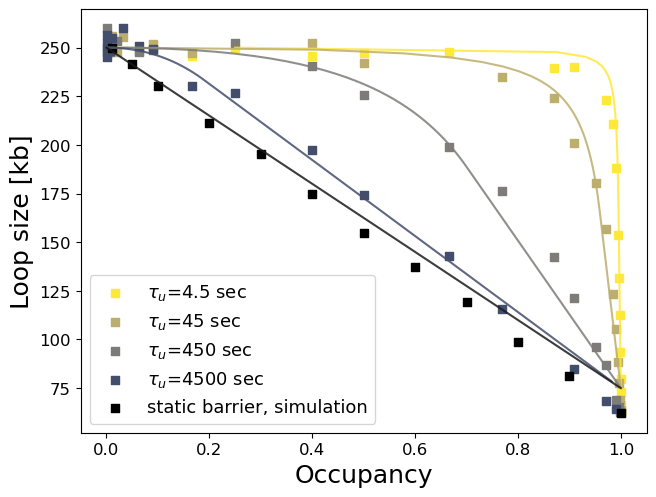

In [19]:
lifes, vels = [500] , [1]
import seaborn as sns
convertor=3
i=1
file = pd.read_csv('../../../../../data/loop_size_converged_pair.csv')
sns.reset_defaults()
plt.figure(figsize=(7.3,5.5))
lifetime = file['life']
velocity = file['vel']
clife = file['clife']
cof = file['cof']
unique_life = np.unique(lifetime)
unique_vel = np.unique(velocity)
unique_clife = np.unique(clife)
unique_cof = np.unique(cof)
cof_val = 10
list_cof = [1.5,15, 150, 1500]
y = [1000, 280]
for cof_val in list_cof:
    for life in lifes:
        for vel in vels:
            v=1
            new_file = file[(lifetime == life)&(velocity == vel)&(cof==cof_val)][['clife','cof', 'loopmean','loopstd']]
            #new_file_filtered = new_file.drop_duplicates(keep = 'first')
            new_file_filtered=new_file
            new_file_filtered = new_file_filtered.sort_values('clife')
            new_clife = new_file_filtered['clife']
            frip_score = new_file_filtered['loopmean']*0.25
            std = new_file_filtered['loopstd']
            plt.scatter(new_clife/(new_clife+cof_val), frip_score,  label = r'$\tau_u$=%s sec'%(cof_val*convertor),
                        linewidth=1,s=31.5, marker = 's', color = colors[5-i])
            i+=1
            #plt.errorbar(new_clife/(new_clife+cof_val), frip_score, yerr= std, label = r'$\tau\prime$=%s'%cof_val,linewidth=1, color = colors[i])
            #plt.plot(new_clife/(new_clife+cof_val), frip_score, linewidth=1.5, color = colors[i],alpha = 1)

x = [0, 1]
file_5000 = file[(file['life']==500)&(file['vel']==1.0)&(file['cof']==5000)]
file_5000 = file_5000.sort_values('clife')
#print(file_5000)
y = [997.746284, 276.690274]
lifes, vels = [500] , [1]


i=1

lifetime = file_stat['life']
velocity = file_stat['vel']
clife = file_stat['clife']
cof = file_stat['cof']
face_prob = file_stat['face']
unique_life = np.unique(lifetime)
unique_vel = np.unique(velocity)
unique_clife = np.unique(clife)
unique_cof = np.unique(cof)
unique_faces = np.unique(face_prob)
faces = unique_faces
cof_val = 10
print(unique_cof)
x = [0, 1]
y = [1000, 280]
for life in lifes:
    for vel in vels:
        i+=1
        new_file = file_stat[(lifetime == 50)&(velocity == vel)&(cof==0.15)][['face', 'loopmean']]
        #new_file_filtered = new_file.drop_duplicates(keep = 'first')
        new_file_filtered=new_file
        new_file_filtered = new_file_filtered.sort_values('face')
        new_face = new_file_filtered['face']
        frip_score = new_file_filtered['loopmean']*0.25
        plt.scatter(new_face, frip_score, label = r'static barrier, simulation',linewidth=1,s=31.5, marker = 's',color = 'black')
        #plt.plot(new_face, frip_score, '--k',linewidth=1.5, alpha = 1)


loop_for_high = []  # Renamed list to avoid conflict with function name
lifetime_range = [500]
#taup_range = [1.5,15, 50, 150,500, 1500, 5000]
tau_range = np.arange(0.5,85000,10)
v_val_range = [1]
delta_val = 300
sep = 1000
i=1
for v_val in v_val_range:
    for taup_val in list_cof:
        for lifetime in lifetime_range:
            v=1
            loop_s = []
            for tau_val in tau_range:
                #x_vals = np.linspace(1, 1, 1)
                #loop_sizes = np.array([loop_size(lifetime, v_val, delta_val, tau_val, x, taup_val) for x in x_vals])
                #integral = np.trapz(loop_sizes, x_vals)
                #integral = np.mean(loop_sizes)
                loop_size_new = loop_size(lifetime, v_val, delta_val, tau_val, taup_val)*0.25
                loop_s.append([tau_val/(tau_val+taup_val), loop_size_new])
            loop_s = np.array(loop_s)
            plt.plot(loop_s[:,0],loop_s[:,1],  alpha = 0.85, color= colors[5-i])#label=r'$\tau\prime$=%s'%(taup_val),
            i+=1

occupancy_range = np.arange(0,1.05,0.05)
lifetime_val = 500
loop_stat=[]
for occupancy_val in occupancy_range:
    loop_s = loop_size_static(lifetime_val,v=v_val,delta=delta_val,occupancy=occupancy_val)*0.25
    loop_stat.append([occupancy_val,loop_s])
loop_stat = np.array(loop_stat)
plt.plot(loop_stat[:,0],loop_stat[:,1],'-k',alpha = 0.85)#,label='static barrier')
plt.ylabel('Loop size [kb]', fontsize = 18)
plt.xlabel(r'Occupancy', fontsize = 18)
plt.xticks(fontsize = 11.95)
plt.yticks(fontsize =11.95)
plt.legend(fontsize=12.95)
plt.savefig('output/figures/analytical_for_loop_size.pdf',transparent =True)
plt.show()  


In [20]:
def loop_size(t, v, delta, tau, x , taup):
    if v * t <= delta/2:
        return v * t * 2
    else:
        loop = delta + (taup / (tau + taup)) * v * (t - (delta/2 / v)) * 2
        if t > (x*tau+(delta/2)/(v)):
            loop += (tau / (tau + taup))* v * (t - (delta/2 / v) - tau*x) * 2
        return loop
s=loop_size(500, 1, 300, 150, 1, 0.0015) 
#print(s)
s=loop_size(500, 1, 300, 15000, 0.1, 0.000015) 


In [20]:



filename = 'folder_face_1.0_back_0_Clife_1.5_Cof_0.15_life_500.0_slife_500.0_birth_0.1_pause_0.9_sep_300_site_10_monomer_1000_replica_10_steps_20.0_vel_1'

params = [ast.literal_eval(i) for i in filename.split('folder_')[1].split('_')[1::2]]
face, back, clife, cof, life, slife, birth, pause, sep, site, monomer, replica, steps, vel = params

In [21]:
paramdict_CTCF={
            'CTCF_facestall':[1, 1],
            'CTCF_backstall':[0, 0],
            'CTCF_lifetime':[clife, clife],
            'CTCF_offtime':[cof, cof],
            'LEF_lifetime':[life, life],
            'LEF_stalled_lifetime':[slife, slife],
            'LEF_birth':[0, 0.1],
            'LEF_pause':[0.9, 0.9],
            'LEF_separation':3000,
            'sites_per_monomer':10,
            'monomers_per_replica':3000,
            'number_of_replica':1,
            'steps':200,
            'velocity_multiplier':vel
            }

In [22]:
monomers_per_replica = paramdict_CTCF['monomers_per_replica']
sites_per_monomer = paramdict_CTCF['sites_per_monomer']
sites_per_replica = monomers_per_replica*sites_per_monomer
monomer_types = np.zeros(monomers_per_replica, dtype=int)
site_types = np.repeat(monomer_types, sites_per_monomer)
#print(len(site_types))

# Let's make some strong and weak CTCF regions
typedict = {'strong_CTCF':1, 'weak_CTCF':0}
site_types[15000:15300] = typedict['strong_CTCF']
site_types[:15000] = site_types[15300:] = typedict['weak_CTCF']


# LEF/CTCF properties in type A monomers may be obtained from the paramdict as follows
LEF_lifetime = paramdict_CTCF['LEF_lifetime'][1]
LEF_velocity = paramdict_CTCF['velocity_multiplier']
CTCF_facestall = paramdict_CTCF['CTCF_facestall']
CTCF_offtime = paramdict_CTCF['CTCF_offtime']
#print(CTCF_offtime[typedict['strong_CTCF']], CTCF_offtime[typedict['weak_CTCF']])

# Create some CTCF boundary sites
CTCF_left_positions = np.array([15000])
CTCF_right_positions = np.array([15300])


### derivative analysis of convergent simulation

In [18]:
file = pd.read_csv('../../../../../data/loop_size_converged_pair_hreso.csv')
file

,life,vel,clife,cof,loopmean,loopstd
0,500.0,1.0,5.0,150.00,996.032712,-9.920811e+05
1,500.0,1.0,400.0,100000.00,1002.285815,-1.004577e+06
2,500.0,1.0,4500.0,500.00,389.451378,-1.516724e+05
3,500.0,1.0,10.0,200.00,984.319401,-9.688847e+05
4,500.0,1.0,5000.0,100.00,337.452073,-1.138739e+05
...,...,...,...,...,...,...
1705,500.0,1.0,5.0,1.00,1011.043925,-1.022210e+06
1706,500.0,1.0,15.0,10.00,991.485042,-9.830426e+05
1707,500.0,1.0,15.0,300.00,999.396567,-9.987935e+05
1708,500.0,1.0,1500.0,100000.00,976.822982,-9.541831e+05


In [19]:
file = file[file['vel']==1]
file

,life,vel,clife,cof,loopmean,loopstd
0,500.0,1.0,5.0,150.00,996.032712,-9.920811e+05
1,500.0,1.0,400.0,100000.00,1002.285815,-1.004577e+06
2,500.0,1.0,4500.0,500.00,389.451378,-1.516724e+05
3,500.0,1.0,10.0,200.00,984.319401,-9.688847e+05
4,500.0,1.0,5000.0,100.00,337.452073,-1.138739e+05
...,...,...,...,...,...,...
1705,500.0,1.0,5.0,1.00,1011.043925,-1.022210e+06
1706,500.0,1.0,15.0,10.00,991.485042,-9.830426e+05
1707,500.0,1.0,15.0,300.00,999.396567,-9.987935e+05
1708,500.0,1.0,1500.0,100000.00,976.822982,-9.541831e+05


In [20]:
lifetime = file['life']
velocity = file['vel']
clife = file['clife']
cof = file['cof']
unique_life = np.unique(lifetime)
unique_vel = np.unique(velocity)
unique_clife = np.unique(clife)
unique_cof = np.unique(cof)

In [21]:
# adding a column for occupancy in data frame as a funciton of binding and unbinding time
file['occupancy']=file['clife']/(file['cof']+file['clife'])
file['occupancy'] = file['occupancy'].round(2)
file

/home1/rahmanin/.conda/envs/openmm-env/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home1/rahmanin/.conda/envs/openmm-env/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,life,vel,clife,cof,loopmean,loopstd,occupancy
0,500.0,1.0,5.0,150.00,996.032712,-9.920811e+05,0.03
1,500.0,1.0,400.0,100000.00,1002.285815,-1.004577e+06,0.00
2,500.0,1.0,4500.0,500.00,389.451378,-1.516724e+05,0.90
3,500.0,1.0,10.0,200.00,984.319401,-9.688847e+05,0.05
4,500.0,1.0,5000.0,100.00,337.452073,-1.138739e+05,0.98
...,...,...,...,...,...,...,...
1705,500.0,1.0,5.0,1.00,1011.043925,-1.022210e+06,0.83
1706,500.0,1.0,15.0,10.00,991.485042,-9.830426e+05,0.60
1707,500.0,1.0,15.0,300.00,999.396567,-9.987935e+05,0.05
1708,500.0,1.0,1500.0,100000.00,976.822982,-9.541831e+05,0.01


In [22]:
unique_occupancy=np.unique(file['occupancy'])

In [11]:
# defining colors as cividis 
num_plot =15
viridis_cmap = plt.get_cmap('cividis')

# Generate an array of values from 0 to 1 to map to colors in the colormap
values = np.linspace(0, 1, num_plot)

# Get the corresponding colors from the colormap
colors = viridis_cmap(values)
colors=list(colors)
colors.reverse()

In [12]:
from polychrom.polymer_analyses import slope_contact_scaling
from scipy.ndimage import gaussian_filter1d
def smooth(x, sigma = 0.1075):
        return gaussian_filter1d(x, sigma)

 this is 0.5
 this is 0.71
 this is 0.75
 this is 0.8
 this is 0.85
 this is 0.9
 this is 0.91
 this is 0.92
 this is 0.93
 this is 0.97


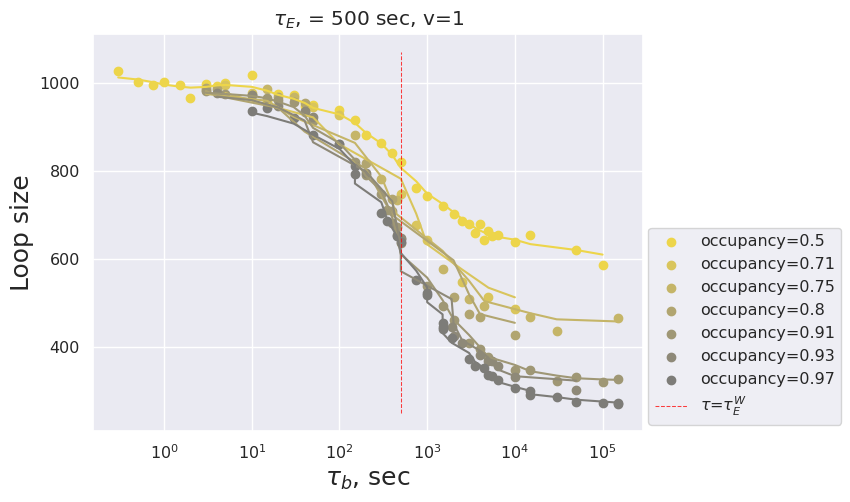

In [13]:
lifes, vels = [500] , [1]

occupancy=file['occupancy']
#list_occup = [ 0.91, 0.75, 0.67, 0.5, ]
#convertor = 25*60/500
convertor = 1
#list_occup=[0.67]
i=1
plt.figure(figsize=(8.5,5))
#file=file[(file['occupancy']>0.9)&(file['occupancy']<0.94)]
unique_occupancy = [0.5,0.71, 0.75, 0.8, 0.85, 0.9, 0.91, 0.92, 0.93, 0.97]
for life in lifes:
    for vel in vels:
        for occup in unique_occupancy:
            print(' this is %s'%occup)
            if (life==1500 and vel==3): continue
            new_file = file[(lifetime == life)&(velocity == vel)&(occupancy==occup)][['clife','cof', 'loopmean']]
            #print(new_file)
            if len(new_file)<10: continue
            new_file_filtered = new_file.drop_duplicates(keep = 'first')
            new_file_filtered = new_file_filtered.sort_values('clife')
            new_clife = new_file_filtered['clife']
            loop_size = new_file_filtered['loopmean']
            plt.scatter(new_clife[1:]*convertor, loop_size[1:], color=colors[i],label=r'occupancy=%s'%(occup))
            plt.plot(new_clife[1:]*convertor, smooth(loop_size[1:],1.5), color=colors[i],alpha = 1)
            i+=1

life_w = 500*convertor
delta = 350*convertor
plt.plot([life_w, life_w, life_w],[250,500,1071],'--', color = 'red',alpha = 0.75, linewidth = 0.75, label = r'$\tau$=$\tau^W_E$')
#plt.plot([life_w-delta, life_w-delta, life_w-delta],[0,0.3,0.451],'--', color = 'blue',
#         alpha = 0.75, linewidth = 0.75, label = r'$\tau$$\sim$$\tau^W_E-\delta$')
        #plt.ylim(0,0.5)
plt.xlim()
plt.title(r'$\tau_E$, = %s sec, v=1'%(life*convertor),fontsize=14.5)
plt.xscale('log')
plt.xticks(fontsize=11.5)
plt.yticks(fontsize=11.5)
plt.legend(fontsize = 11.51,loc = (1.01,0.015))
plt.ylabel('Loop size',fontsize = 18)
plt.xlabel(r'$\tau_b$, sec', fontsize = 18)
plt.tight_layout()
#plt.savefig('../../images/frip_for_tau.pdf',transparent=True)

plt.show()


 this is 0.71
 this is 0.75
 this is 0.76
 this is 0.8
 this is 0.85
 this is 0.9
 this is 0.91
 this is 0.92
 this is 0.97


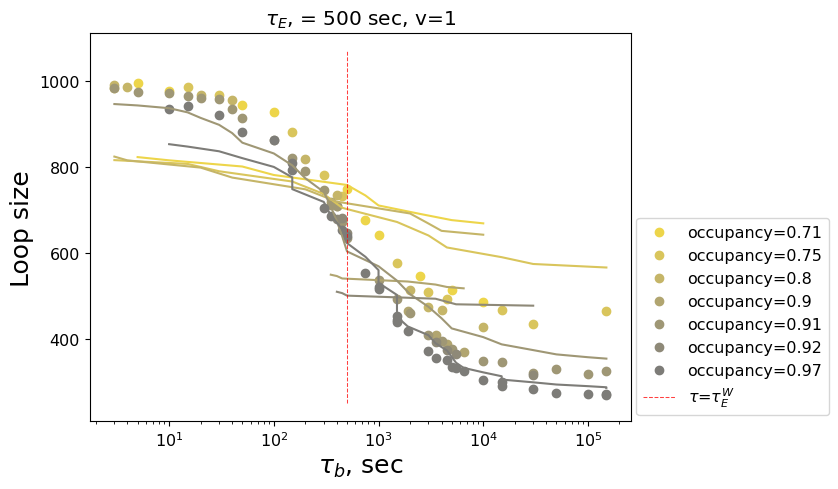

In [17]:
lifes, vels = [500] , [1]

occupancy=file['occupancy']
#list_occup = [ 0.91, 0.75, 0.67, 0.5, ]
#convertor = 25*60/500
convertor = 1
#list_occup=[0.67]
i=1
plt.figure(figsize=(8.5,5))
sns.reset_defaults()
#file=file[(file['occupancy']>0.9)&(file['occupancy']<0.94)]
unique_occupancy = [0.71, 0.75, 0.76,0.8, 0.85, 0.9, 0.91, 0.92, 0.97]
for life in lifes:
    for vel in vels:
        for occup in unique_occupancy:
            print(' this is %s'%occup)
            if (life==1500 and vel==3): continue
            new_file = file[(lifetime == life)&(velocity == vel)&(occupancy==occup)][['clife','cof', 'loopmean']]
            #print(new_file)
            if len(new_file)<5: continue
            new_file_filtered = new_file.drop_duplicates(keep = 'first')
            new_file_filtered = new_file_filtered.sort_values('clife')
            new_clife = new_file_filtered['clife']
            loop_size = new_file_filtered['loopmean']
            plt.scatter(new_clife[1:]*convertor, loop_size[1:], color=colors[i],label=r'occupancy=%s'%(occup))
            plt.plot(new_clife[1:]*convertor, smooth(loop_size[1:],5), color=colors[i],alpha = 1)
            i+=1

life_w = 500*convertor
delta = 350*convertor
plt.plot([life_w, life_w, life_w],[250,500,1071],'--', color = 'red',alpha = 0.75, linewidth = 0.75, label = r'$\tau$=$\tau^W_E$')
#plt.plot([life_w-delta, life_w-delta, life_w-delta],[0,0.3,0.451],'--', color = 'blue',
#         alpha = 0.75, linewidth = 0.75, label = r'$\tau$$\sim$$\tau^W_E-\delta$')
        #plt.ylim(0,0.5)
plt.xlim()
plt.title(r'$\tau_E$, = %s sec, v=1'%(life*convertor),fontsize=14.5)
plt.xscale('log')
plt.xticks(fontsize=11.5)
plt.yticks(fontsize=11.5)
plt.legend(fontsize = 11.51,loc = (1.01,0.015))
plt.ylabel('Loop size',fontsize = 18)
plt.xlabel(r'$\tau_b$, sec', fontsize = 18)
plt.tight_layout()
#plt.savefig('../../images/frip_for_tau.pdf',transparent=True)

plt.show()


 this is 0.5
 this is 0.75
 this is 0.91


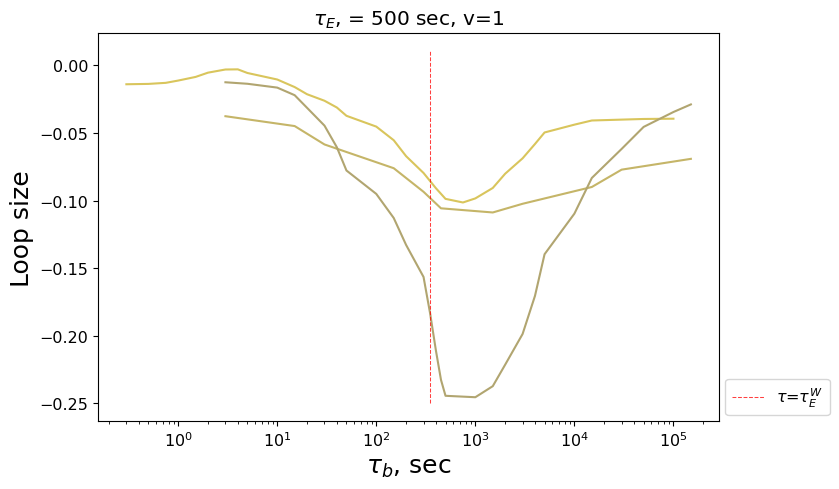

In [21]:
lifes, vels = [500] , [1]

occupancy=file['occupancy']
#list_occup = [ 0.91, 0.75, 0.67, 0.5, ]
#convertor = 25*60/500
convertor = 1
#list_occup=[0.67]
i=1
plt.figure(figsize=(8.5,5))
#file=file[(file['occupancy']>0.9)&(file['occupancy']<0.94)]
unique_occupancy = [0.5,0.75, 0.91]
for life in lifes:
    for vel in vels:
        for occup in unique_occupancy:
            print(' this is %s'%occup)
            if (life==1500 and vel==3): continue
            new_file = file[(lifetime == life)&(velocity == vel)&(occupancy==occup)][['clife','cof', 'loopmean']]
            #print(new_file)
            if len(new_file)<5: continue
            new_file_filtered = new_file.drop_duplicates(keep = 'first')
            new_file_filtered = new_file_filtered.sort_values('clife')
            new_clife = new_file_filtered['clife']
            loop_size = new_file_filtered['loopmean']
            #plt.scatter(new_clife[1:]*convertor, loop_size[1:], color=colors[i],label=r'occupancy=%s'%(occup))
            #plt.plot(new_clife[1:]*convertor, smooth(loop_size[1:],0.05), color=colors[i],alpha = 1)
            i+=1
            s, der = slope_contact_scaling(new_clife, loop_size)#smooth(loop_size, sigma=0.3195))
            #print(s)
            #print('der is %s'%der)
            #sp, derp = slope_contact_scaling(s, der, sigma=1.5)
            plt.plot(s*convertor, smooth(der,1.5), color=colors[i])

life_w = 350*convertor
delta = 350*convertor
plt.plot([life_w, life_w, life_w],[-.250,-0.200,0.01071],'--', color = 'red',alpha = 0.75, linewidth = 0.75, label = r'$\tau$=$\tau^W_E$')
#plt.plot([life_w-delta, life_w-delta, life_w-delta],[0,0.3,0.451],'--', color = 'blue',
#         alpha = 0.75, linewidth = 0.75, label = r'$\tau$$\sim$$\tau^W_E-\delta$')
        #plt.ylim(0,0.5)
plt.xlim()
plt.title(r'$\tau_E$, = %s sec, v=1'%(life*convertor),fontsize=14.5)
plt.xscale('log')
plt.xticks(fontsize=11.5)
plt.yticks(fontsize=11.5)
plt.legend(fontsize = 11.51,loc = (1.01,0.015))
plt.ylabel('Loop size',fontsize = 18)
plt.xlabel(r'$\tau_b$, sec', fontsize = 18)
plt.tight_layout()
#plt.savefig('../../images/frip_for_tau.pdf',transparent=True)

plt.show()


### investigating the derivative

 this is 0.91
500 1


/home1/rahmanin/.conda/envs/openmm-env/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


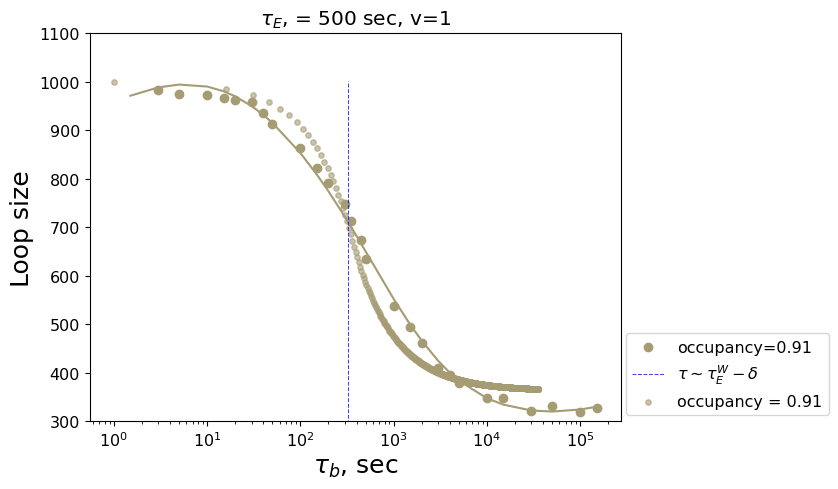

In [158]:
lifes, vels = [500] , [1]

occupancy=file['occupancy']
#list_occup = [ 0.91, 0.75, 0.67, 0.5, ]
#convertor = 25*60/500
convertor = 1
#list_occup=[0.67]
i=1
plt.figure(figsize=(8.5,5))
#file=file[(file['occupancy']>0.9)&(file['occupancy']<0.94)]
#unique_occupancy = [0.5,0.71, 0.75, 0.8, 0.85, 0.9, 0.91, 0.92, 0.93, 0.97]
unique_occupancy =[  0.91]
# defining colors as cividis 
num_plot =7
viridis_cmap = plt.get_cmap('cividis')

# Generate an array of values from 0 to 1 to map to colors in the colormap
values = np.linspace(0, 1, num_plot)

# Get the corresponding colors from the colormap
colors = viridis_cmap(values)
colors=list(colors)
colors.reverse()
for life in lifes:
    for vel in vels:
        for occup in unique_occupancy:
            print(' this is %s'%occup)
            if (life==1500 and vel==3): continue
            new_file = file[(lifetime == life)&(velocity == vel)&(occupancy==occup)][['clife','cof', 'loopmean']]
            #print(new_file)
            if len(new_file)<10: continue
            new_file_filtered = new_file.drop_duplicates(keep = 'first')
            new_file_filtered = new_file_filtered.sort_values('clife')
            new_clife = new_file_filtered['clife']
            loop_size = new_file_filtered['loopmean']
            s, der = slope_contact_scaling(new_clife, loop_size)#smooth(loop_size, sigma=0.3195))
            #plt.scatter(1*s*convertor, der, color=colors[i])
            i+=1
            new_clife = np.delete(np.array(new_clife), 14)
            loop_size = np.delete(np.array(loop_size), 14)
            plt.scatter(new_clife[1:]*convertor, loop_size[1:], color=colors[i],label=r'occupancy=%s'%(occup))
            x= np.log(new_clife)
            f = splrep(x, np.log(loop_size), k=3, s=0.01)
            plt.plot(np.exp(x)*convertor, np.exp(splev(x,f)), color=colors[i],alpha = 1)
            

life_w = 500*convertor
delta = 350*convertor
print(life_w, convertor)
#plt.plot([life_w, life_w, life_w],[250,500,1071],'--', color = 'red',alpha = 0.75, linewidth = 0.75, label = r'$\tau$=$\tau^W_E$')
plt.plot([life_w-delta/2, life_w-delta/2, life_w-delta/2],[0,100,1001],'--', color = 'blue',
         alpha = 0.75, linewidth = 0.75, label = r'$\tau$$\sim$$\tau^W_E-\delta$')

def loop_size(t, v, delta, tau,  taup):
    if v * t <= delta/2:
        return v * t * 2
    else:
        loop = delta + (taup / (tau + taup)) * v * (t - (delta/2 / v)) * 2 + (tau / ((tau + taup)*tau)) * v * ((t - (delta/2 / v))**2)
        if t > (tau+(delta/2)/(v)):
            loop = delta + (taup / (tau + taup)) * v * (t - (delta/2 / v)) * 2+(tau / (tau + taup)) * v * (t - (delta/2 / v) - tau/2) * 2
        return loop
loop_for_high = []  # Renamed list to avoid conflict with function name
lifetime_range = [500]
taup_range = [1.5,15, 50, 150,500, 1500, 5000]
tau_range = np.arange(1,35000,15)
occup_range = unique_occupancy
v_val_range = [1]
delta_val = 300
sep = 1000
i=1
sns.reset_defaults()
#convertor = 21.875*60/500
#colors = viridis_cmap(np.linspace(0, 1, 10))
for v_val in v_val_range:
    for occupa in occup_range:
        for lifetime in lifetime_range:
            i+=1
            loop_s = []
            for tau_val in tau_range:
                #x_vals = np.linspace(0.1, 1, 1000)
                taup_val = tau_val*(1-occupa)/occupa
                occup = np.round(tau_val/(tau_val+taup_val),3)
                #loop_sizes = np.array([loop_size(lifetime, v_val, delta_val, tau_val, x, taup_val) for x in x_vals])
                #integral = np.trapz(loop_sizes, x_vals)
                #integral = np.mean(loop_sizes)
                loop_size_new = loop_size(lifetime, v_val, delta_val, tau_val, taup_val)
                #loop_s.append([tau_val/(tau_val+taup_val), loop_size_new])
                loop_s.append([tau_val, loop_size_new])
            loop_s = np.array(loop_s)
            s, der = slope_contact_scaling(loop_s[:,0],loop_s[:,1], sigma=1)
            #plt.scatter(loop_s[:,0],loop_s[:,1],label=r'$occupancy$=%s'%(multip/(1+multip)), s=3, alpha = 0.5, color= colors[i])
            plt.scatter(loop_s[:,0],loop_s[:,1], s =15, alpha=0.6, color=colors[i],label = 'occupancy = %s'%occup)
            #loop_s = np.array(loop_s)
            #plt.scatter(loop_s[:,0],loop_s[:,1],label=r'$occupancy$=%s'%(multip/(1+multip)), s=3, alpha = 0.5, color= colors[i])
point = (lifetime-delta_val/(2*v_val))*convertor
#plt.plot([point,point] ,[-0.5, 0.01],color='red', label = r'$\tau_E-\dfrac{\delta}{v}$')




plt.ylim(300,1100)
plt.xlim()
plt.title(r'$\tau_E$, = %s sec, v=1'%(life*convertor),fontsize=14.5)
plt.xscale('log')
plt.xticks(fontsize=11.5)
plt.yticks(fontsize=11.5)
plt.legend(fontsize = 11.51,loc = (1.01,0.015))
plt.ylabel('Loop size',fontsize = 18)
plt.xlabel(r'$\tau_b$, sec', fontsize = 18)
plt.tight_layout()
#plt.savefig('../../images/frip_for_tau.pdf',transparent=True)

plt.show()


 this is 0.91
1312.5 2.625


/home1/rahmanin/.conda/envs/openmm-env/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


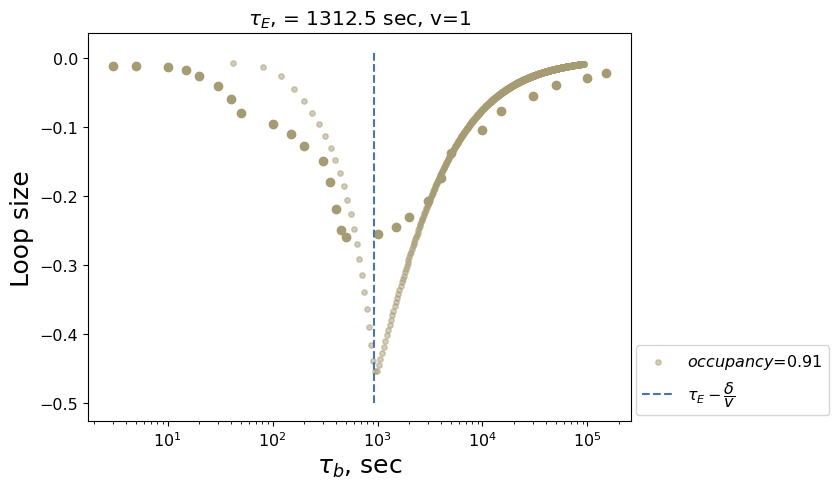

In [100]:
lifes, vels = [500] , [1]

occupancy=file['occupancy']
#list_occup = [ 0.91, 0.75, 0.67, 0.5, ]
#convertor = 25*60/500
convertor = 21.875*60/500
#list_occup=[0.67]
i=1
plt.figure(figsize=(8.5,5))
#file=file[(file['occupancy']>0.9)&(file['occupancy']<0.94)]
#unique_occupancy = [0.5,0.71, 0.75, 0.8, 0.85, 0.9, 0.91, 0.92, 0.93, 0.97]
unique_occupancy =[   0.91]
# defining colors as cividis 
num_plot =7
viridis_cmap = plt.get_cmap('cividis')

# Generate an array of values from 0 to 1 to map to colors in the colormap
values = np.linspace(0, 1, num_plot)

# Get the corresponding colors from the colormap
colors = viridis_cmap(values)
colors=list(colors)
colors.reverse()
for life in lifes:
    for vel in vels:
        for occup in unique_occupancy:
            i+=1
            print(' this is %s'%occup)
            if (life==1500 and vel==3): continue
            new_file = file[(lifetime == life)&(velocity == vel)&(occupancy==occup)][['clife','cof', 'loopmean']]
            #print(new_file)
            if len(new_file)<10: continue
            new_file_filtered = new_file.drop_duplicates(keep = 'first')
            new_file_filtered = new_file_filtered.sort_values('clife')
            new_clife = new_file_filtered['clife']
            loop_size = new_file_filtered['loopmean']
            s, der = slope_contact_scaling(new_clife, loop_size)#smooth(loop_size, sigma=0.3195))
            plt.scatter(1*s*convertor, der, color=colors[i])
            
            #plt.scatter(new_clife[1:]*convertor, loop_size[1:], color=colors[i],label=r'occupancy=%s'%(occup))
            #plt.plot(new_clife[1:]*convertor, smooth(loop_size[1:], 0.11), color=colors[i],alpha = 1)

life_w = 500*convertor
delta = 350*convertor
print(life_w, convertor)
#plt.plot([life_w, life_w, life_w],[250,500,1071],'--', color = 'red',alpha = 0.75, linewidth = 0.75, label = r'$\tau$=$\tau^W_E$')
#plt.plot([life_w-delta/2, life_w-delta/2, life_w-delta/2],[0,100,1001],'--', color = 'blue',alpha = 0.75, linewidth = 0.75, label = r'$\tau$$\sim$$\tau^W_E-\delta$')

def loop_size(t, v, delta, tau,  taup):
    if v * t <= delta/2:
        return v * t * 2
    else:
        loop = delta + (taup / (tau + taup)) * v * (t - (delta/2 / v)) * 2 + (tau / ((tau + taup)*tau)) * v * ((t - (delta/2 / v))**2)
        if t > (tau+(delta/2)/(v)):
            loop = delta + (taup / (tau + taup)) * v * (t - (delta/2 / v)) * 2+(tau / (tau + taup)) * v * (t - (delta/2 / v) - tau/2) * 2
        return loop
loop_for_high = []  # Renamed list to avoid conflict with function name
lifetime_range = [500]
taup_range = [1.5,15, 50, 150,500, 1500, 5000]
tau_range = np.arange(1,35000,15)
occup_range = unique_occupancy
v_val_range = [1]
delta_val = 300
sep = 1000
i=1
sns.reset_defaults()
#convertor = 21.875*60/500
#colors = viridis_cmap(np.linspace(0, 1, 10))
for v_val in v_val_range:
    for occupa in occup_range:
        for lifetime in lifetime_range:
            i+=1
            loop_s = []
            for tau_val in tau_range:
                #x_vals = np.linspace(0.1, 1, 1000)
                taup_val = tau_val*(1-occupa)/occupa
                occup = np.round(tau_val/(tau_val+taup_val),3)
                #loop_sizes = np.array([loop_size(lifetime, v_val, delta_val, tau_val, x, taup_val) for x in x_vals])
                #integral = np.trapz(loop_sizes, x_vals)
                #integral = np.mean(loop_sizes)
                loop_size_new = loop_size(lifetime, v_val, delta_val, tau_val, taup_val)
                #loop_s.append([tau_val/(tau_val+taup_val), loop_size_new])
                loop_s.append([tau_val, loop_size_new])
            loop_s = np.array(loop_s)
            s, der = slope_contact_scaling(loop_s[:,0], (loop_s[:,1]), sigma=1)
            #plt.scatter(loop_s[:,0],loop_s[:,1],label=r'$occupancy$=%s'%(multip/(1+multip)), s=3, alpha = 0.5, color= colors[i])
            #plt.scatter(loop_s[:,0],loop_s[:,1], s =15, alpha=0.6, color=colors[i],label = 'occupancy = %s'%occup)
            #loop_s = np.array(loop_s)
            plt.scatter(s*convertor,der,label=r'$occupancy$=%s'%(occupa), s=15, alpha = 0.5, color= colors[i])
point = (lifetime-delta_val/(2*v_val))*convertor
plt.plot([point,point] ,[-0.5, 0.01],'--b', label = r'$\tau_E-\dfrac{\delta}{v}$')




#plt.ylim(300,1100)
plt.xlim()
plt.title(r'$\tau_E$, = %s sec, v=1'%(life*convertor),fontsize=14.5)
plt.xscale('log')
plt.xticks(fontsize=11.5)
plt.yticks(fontsize=11.5)
plt.legend(fontsize = 11.51,loc = (1.01,0.015))
plt.ylabel('Loop size',fontsize = 18)
plt.xlabel(r'$\tau_b$, sec', fontsize = 18)
plt.tight_layout()
#plt.savefig('../../images/frip_for_tau.pdf',transparent=True)

plt.show()


/home1/rahmanin/.conda/envs/openmm-env/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


 this is 0.33
 this is 0.5
 this is 0.67
 this is 0.83
 this is 0.91
500 1


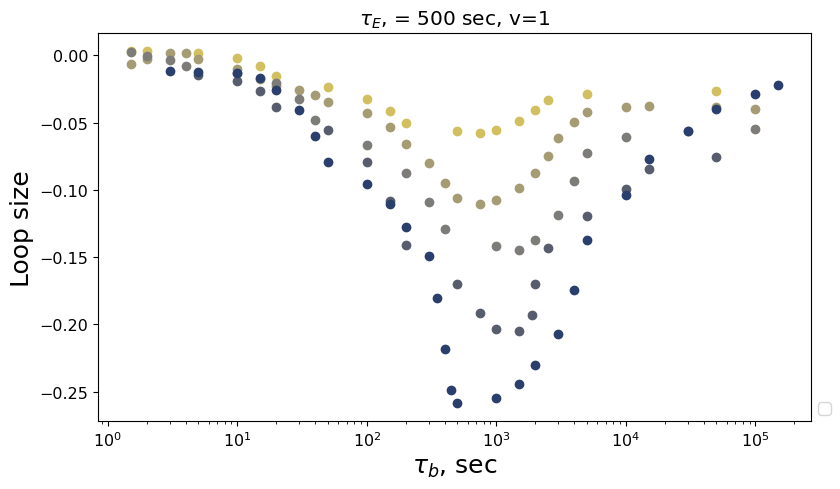

In [23]:
lifes, vels = [500] , [1]

occupancy=file['occupancy']
#list_occup = [ 0.91, 0.75, 0.67, 0.5, ]
#convertor = 25*60/500
convertor = 1
#list_occup=[0.67]
i=1
plt.figure(figsize=(8.5,5))
#file=file[(file['occupancy']>0.9)&(file['occupancy']<0.94)]
#unique_occupancy = [0.5,0.71, 0.75, 0.8, 0.85, 0.9, 0.91, 0.92, 0.93, 0.97]
unique_occupancy =[ 0.33, 0.5, 0.67, 0.83, 0.91]
# defining colors as cividis 
num_plot =7
viridis_cmap = plt.get_cmap('cividis')

# Generate an array of values from 0 to 1 to map to colors in the colormap
values = np.linspace(0, 1, num_plot)

# Get the corresponding colors from the colormap
colors = viridis_cmap(values)
colors=list(colors)
colors.reverse()
for life in lifes:
    for vel in vels:
        for occup in unique_occupancy:
            print(' this is %s'%occup)
            if (life==1500 and vel==3): continue
            new_file = file[(lifetime == life)&(velocity == vel)&(occupancy==occup)][['clife','cof', 'loopmean']]
            #print(new_file)
            if len(new_file)<10: continue
            new_file_filtered = new_file.drop_duplicates(keep = 'first')
            new_file_filtered = new_file_filtered.sort_values('clife')
            new_clife = new_file_filtered['clife']
            loop_size = new_file_filtered['loopmean']
            s, der = slope_contact_scaling(new_clife, loop_size)#smooth(loop_size, sigma=0.3195))
            plt.scatter(1*s*convertor, der, color=colors[i])
            i+=1
            #plt.scatter(new_clife[1:]*convertor, loop_size[1:], color=colors[i],label=r'occupancy=%s'%(occup))
            #plt.plot(new_clife[1:]*convertor, (loop_size[1:]), color=colors[i],alpha = 1)

life_w = 500*convertor
delta = 350*convertor
print(life_w, convertor)
#plt.plot([life_w, life_w, life_w],[250,500,1071],'--', color = 'red',alpha = 0.75, linewidth = 0.75, label = r'$\tau$=$\tau^W_E$')
#plt.plot([life_w-delta, life_w-delta, life_w-delta],[0,0.3,0.451],'--', color = 'blue',
#         alpha = 0.75, linewidth = 0.75, label = r'$\tau$$\sim$$\tau^W_E-\delta$')
        #plt.ylim(0,0.5)
plt.xlim()
plt.title(r'$\tau_E$, = %s sec, v=1'%(life*convertor),fontsize=14.5)
plt.xscale('log')
plt.xticks(fontsize=11.5)
plt.yticks(fontsize=11.5)
plt.legend(fontsize = 11.51,loc = (1.01,0.015))
plt.ylabel('Loop size',fontsize = 18)
plt.xlabel(r'$\tau_b$, sec', fontsize = 18)
plt.tight_layout()
#plt.savefig('../../images/frip_for_tau.pdf',transparent=True)

plt.show()


In [21]:
sns.reset_defaults()

In [62]:
import pandas as pd

# Sample DataFrame
data = {
    'occupancy': [0.35, 0.34, 0.33, 0.37, 0.40, 0.43, 0.42, 0.44, 0.46, 0.50]
}
df = pd.DataFrame(data)

# Sort the DataFrame by 'occupancy'
df_sorted = df.sort_values(by='occupancy').reset_index(drop=True)

# Initialize variables
groups = []
current_group = [df_sorted.iloc[0]['occupancy']]

# Group rows within 0.03 of each other
for i in range(1, len(df_sorted)):
    if df_sorted.iloc[i]['occupancy'] - current_group[-1] <= 0.03:
        current_group.append(df_sorted.iloc[i]['occupancy'])
    else:
        groups.append(current_group)
        current_group = [df_sorted.iloc[i]['occupancy']]

# Append the last group
groups.append(current_group)

# Print the groups
for idx, group in enumerate(groups):
    print(f"Group {idx+1}: {group}")
    

Group 1: [0.33, 0.34, 0.35, 0.37]
Group 2: [0.4, 0.42, 0.43, 0.44, 0.46]
Group 3: [0.5]


### derivative analysis of theoretical loop size

In [22]:
def loop_size(t, v, delta, tau, x , taup):
    if v * t <= delta/2:
        return v * t * 2
    else:
        loop = delta + (taup / (tau + taup)) * v * (t - (delta/2 / v)) * 2
        if t > (x*tau+(delta/2)/(v)):
            loop += (tau / (tau + taup)) * v * (t - (delta/2 / v) - tau*x) * 2
        return loop

In [23]:
x_vals = np.linspace(0.01, 1, 10)
loop_sizes = np.array([loop_size(500, 1, 300, 5000, x, 50) for x in x_vals])
integral = np.trapz(loop_sizes, x_vals)


In [24]:
x_vals = np.linspace(0.01, 1, 10)
loop_sizes = np.array([loop_size(500, 1, 300, 5, x, 5000) for x in x_vals])
#print(loop_sizes, x_vals)
x_new_vals = np.linspace(1,10, 10)
integral = np.trapz(loop_sizes, x_vals)
new_int = np.trapz(loop_sizes, x_new_vals)

In [25]:
from polychrom.polymer_analyses import slope_contact_scaling
from scipy.ndimage import gaussian_filter1d

def smooth(x, sigma = 1.75):
        return gaussian_filter1d(x, sigma)

In [26]:
def loop_size(t, v, delta, tau, x , taup):
    if v * t <= delta/2:
        return v * t * 2
    else:
        loop = delta + (taup / (tau + taup)) * v * (t - (delta/2 / v)) * 2
        if t > (x*tau+(delta/2)/(v)):
            loop += (tau / (tau + taup)) * v * (t - (delta/2 / v) - tau*x) * 2
        return loop

In [27]:
def dloop_size(t, v, delta, tau, x , taup):
    if v * t <= delta/2:
        return 0
    else:
        dloop =  (-taup / ((tau + taup)**2)) * v * (t - (delta/2 / v)) * 2
        if t > (x*tau+(delta/2)/(v)):
            loop += (tau / (tau + taup)) * v * (t - (delta/2 / v) - tau*x) * 2
        return loop

In [28]:
num_plot = 15
viridis_cmap = plt.get_cmap('cividis')

# Generate an array of values from 0 to 1 to map to colors in the colormap
values = np.linspace(0, 1, num_plot)

# Get the corresponding colors from the colormap
colors = viridis_cmap(values)

/home1/rahmanin/.conda/envs/openmm-env/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in double_scalars
  
/home1/rahmanin/.conda/envs/openmm-env/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in true_divide
  
/home1/rahmanin/.conda/envs/openmm-env/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in long_scalars
  
/home1/rahmanin/.conda/envs/openmm-env/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in long_scalars
  


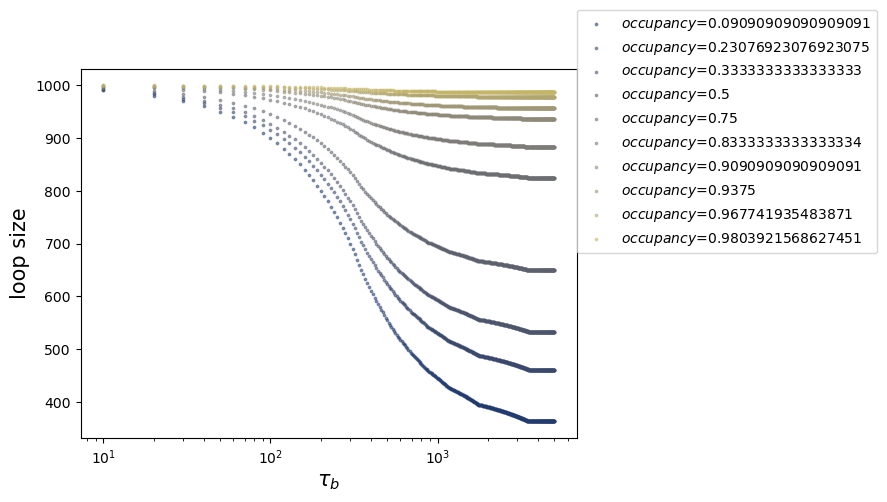

In [29]:
loop_for_high = []  # Renamed list to avoid conflict with function name
lifetime_range = [500]
taup_range = [1.5,15, 50, 150,500, 1500, 5000]
tau_range = np.arange(0,5000,10)
multip_range = [0.1, 0.3, 0.5, 1, 3, 5, 10, 15, 30, 50]
v_val_range = [1]
delta_val = 300
sep = 1000
i=1
def loop_size(t, v, delta, tau, x , taup):
    if v * t <= delta/2:
        return v * t * 2
    else:
        loop = delta + (taup / (tau + taup)) * v * (t - (delta/2 / v)) * 2
        if t > (x*tau+(delta/2)/(v)):
            loop += (tau / (tau + taup)) * v * (t - (delta/2 / v) - tau*x) * 2
        return loop
for v_val in v_val_range:
    for multip in multip_range:
        for lifetime in lifetime_range:
            i+=1
            loop_s = []
            for tau_val in tau_range:
                x_vals = np.linspace(0.1, 1, 10)
                taup_val = tau_val*multip
                loop_sizes = np.array([loop_size(lifetime, v_val, delta_val, tau_val, x, taup_val) for x in x_vals])
                integral = np.trapz(loop_sizes, x_vals)
                integral = np.mean(loop_sizes)
                loop_s.append([tau_val, integral])
            loop_s = np.array(loop_s)
            plt.scatter(loop_s[:,0],loop_s[:,1],label=r'$occupancy$=%s'%(multip/(1+multip)), s=3, alpha = 0.5, color= colors[i])


plt.ylabel('loop size', fontsize = 15)
plt.xlabel(r'$\tau_b$', fontsize = 15)
plt.xscale('log')
plt.legend(loc=(1,0.5))
plt.show()  


In [30]:
num_plot = 12
viridis_cmap = plt.get_cmap('cividis')

# Generate an array of values from 0 to 1 to map to colors in the colormap
values = np.linspace(0, 1, num_plot)

# Get the corresponding colors from the colormap
colors = viridis_cmap(values)

In [31]:
def loop_size(t, v, delta, tau,  taup):
    if v * t <= delta/2:
        return v * t * 2
    else:
        loop = delta + (taup / (tau + taup)) * v * (t - (delta/2 / v)) * 2 + (tau / ((tau + taup)*tau)) * v * ((t - (delta/2 / v))**2)
        if t > (tau+(delta/2)/(v)):
            loop = delta + (taup / (tau + taup)) * v * (t - (delta/2 / v)) * 2+(tau / (tau + taup)) * v * (t - (delta/2 / v) - tau/2) * 2
        return loop

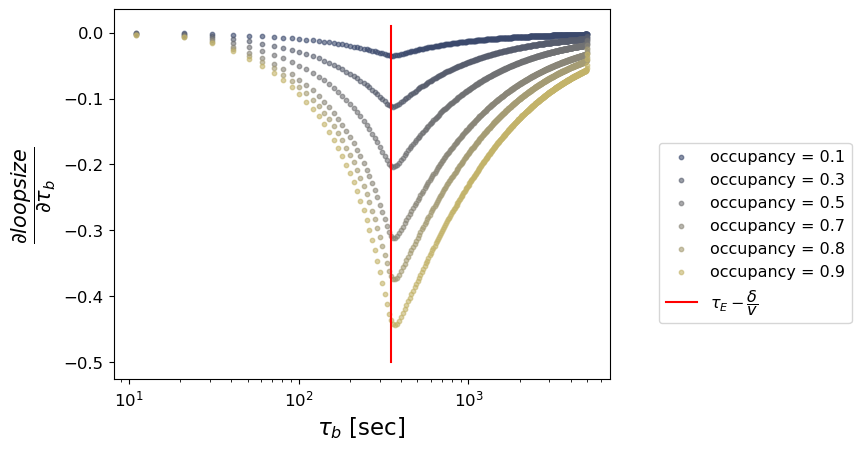

In [33]:
loop_for_high = []  # Renamed list to avoid conflict with function name
lifetime_range = [500]
taup_range = [1.5,15, 50, 150,500, 1500, 5000]
tau_range = np.arange(1,5000,10)
occup_range = [0.1, 0.3, 0.5, 0.7, 0.8, 0.9]
v_val_range = [1]
delta_val = 300
sep = 1000
i=1
sns.reset_defaults()
#convertor = 21.875*60/500
convertor=1
colors = viridis_cmap(np.linspace(0, 1, 10))
for v_val in v_val_range:
    for occupa in occup_range:
        for lifetime in lifetime_range:
            i+=1
            loop_s = []
            for tau_val in tau_range:
                #x_vals = np.linspace(0.1, 1, 1000)
                taup_val = tau_val*(1-occupa)/occupa
                occup = np.round(tau_val/(tau_val+taup_val),3)
                #loop_sizes = np.array([loop_size(lifetime, v_val, delta_val, tau_val, x, taup_val) for x in x_vals])
                #integral = np.trapz(loop_sizes, x_vals)
                #integral = np.mean(loop_sizes)
                loop_size_new = loop_size(lifetime, v_val, delta_val, tau_val, taup_val)
                #loop_s.append([tau_val/(tau_val+taup_val), loop_size_new])
                loop_s.append([tau_val, loop_size_new])
            loop_s = np.array(loop_s)
            s, der = slope_contact_scaling(loop_s[:,0], smooth(loop_s[:,1]), sigma=1)
            #plt.scatter(loop_s[:,0],loop_s[:,1],label=r'$occupancy$=%s'%(multip/(1+multip)), s=3, alpha = 0.5, color= colors[i])
            plt.scatter(s*convertor,der, s =10, alpha=0.6, color=colors[i],label = 'occupancy = %s'%occup)
            #loop_s = np.array(loop_s)
            #plt.scatter(loop_s[:,0],loop_s[:,1],label=r'$occupancy$=%s'%(multip/(1+multip)), s=3, alpha = 0.5, color= colors[i])
point = (lifetime-delta_val/(2*v_val))*convertor
plt.plot([point,point] ,[-0.5, 0.01],color='red', label = r'$\tau_E-\dfrac{\delta}{v}$')

plt.ylabel(r'$\dfrac{\partial loop size}{\partial \tau_b}$', fontsize = 15)
plt.xlabel(r'$\tau_b$ [sec]', fontsize = 16.5)
plt.xscale('log')
plt.xticks(fontsize =11.95)
plt.yticks(fontsize = 11.95)
plt.legend(loc=(1.1,0.15), fontsize = 11.5)
#plt.tight_layout()
plt.savefig('output/figures/loop_derivetive.pdf', transparent = True)
plt.show()  
